# Find n-syll phrases

In [169]:
import sys; sys.path.insert(0,'/Users/ryan/github/cadence/')
import sys; sys.path.insert(0,'/Users/ryan/github/lltk/')
from cadence.imports import *

from ipywidgets import interact, interact_manual, interactive
import plotnine as p9

In [189]:
import lltk
C=lltk.load('Saintsbury')

In [190]:
C.meta

,author,title,year,id_author,author_au,texts,date_au,same_as,need,section,metricality,rythmicity,variability,quality,style,notes_au,x,is_also,genre,source,prosody,addr,date,extent,fnfn_xml,id_eebo_citation,id_oclc,id_proquest,id_rlin,id_stc,id_vid,medium,num_lines,num_paras,num_words,ocr_accuracy,publisher,pubplace,a1,alias,...,sub,subhead,sup,t1,t2,t3,target,title_volume,trailer,ty,u,usonly,video,volhead,xref,y1,year_new,year_old,id_ContentSet,id_DocNo,id_ESTC,id_GaleDocNo,id_ImageSetID,id_TCP,notes,fn,id_tedjdh,num_words2,fn_raw,name,nation,pub,subcorpus,type,path_freqs,path_txt,path_xml,_year_orig,year_orig,corpus
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
en.kjv.prose.kjbible,,King James Bible,NaN,kjv,King James Version,King James Bible,1604-1611,x,x,The Authorized Version and the Triumph of the ...,antimetrical?,x,x,x,x,"""the other harmony"" = prose rhythm",x,,,https://www.gutenberg.org/cache/epub/10/pg10.txt,Prose,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,/Users/ryan/lltk_data/corpora/saintsbury/freqs...,/Users/ryan/lltk_data/corpora/saintsbury/txt/e...,/Users/ryan/lltk_data/corpora/saintsbury/xml/e...,,,Saintsbury
en.wycliffe.prose.EEBO_TCP.0001,"Wycliffe, John, d. 1384.","Tvvo short treatises, against the orders of th...",1608.0,wycliffe,John Wycliffe,Tracts and Sermons,1320-1384,"EEBO_TCP|author==""Wycliffe, John, d. 1384.""",x,From Chaucer to Malory,?,x,x,3,x,Too slavish imitation of Vulgate,x,,Prose,,Prose,EEBO_TCP|A15298,1608.,"[8], 62, [2] p.",/Volumes/Present/DH/corpora/eebo/_xml_eebo_tcp...,99857080.0,,99857080.0,,ESTC S121923,22751.0,Prose,,165.0,19125.0,0.914035223834,"Printed by Ioseph Barnes, printer to the Vnive...",At Oxford :,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,/Users/ryan/lltk_data/corpora/saintsbury/freqs...,/Users/ryan/lltk_data/corpora/saintsbury/txt/e...,/Users/ryan/lltk_data/corpora/saintsbury/xml/e...,1608,1608,Saintsbury
en.wycliffe.prose.EEBO_TCP.0002,"Wycliffe, John, d. 1384.",Wycklyffes wycket whyche he made in Kyng Rycar...,1546.0,wycliffe,John Wycliffe,Tracts and Sermons,1320-1384,"EEBO_TCP|author==""Wycliffe, John, d. 1384.""",x,From Chaucer to Malory,?,x,x,3,x,Too slavish imitation of Vulgate,x,,Prose,,Prose,EEBO_TCP|A15299,1546],[38] p.,/Volumes/Present/DH/corpora/eebo/_xml_eebo_tcp...,99856819.0,,99856819.0,,ESTC S121648,22451.0,Prose,,2554.0,22366.0,0.92059861456,"J. Daye?],",[Imprinted at Norenburch [i.e. London :,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,/Users/ryan/lltk_data/corpora/saintsbury/freqs...,/Users/ryan/lltk_data/corpora/saintsbury/txt/e...,/Users/ryan/lltk_data/corpora/saintsbury/xml/e...,1546,1546,Saintsbury
en.mandeville.prose.EEBO_TCP.0003,"Mandeville, John, Sir.",[Here endeth the boke of Iohn Maunduyle knyght...,1496.0,mandeville,Sir John Mandeville,The Voiage and Travaile of Sir John Maundevile,1300-1371,"EEBO_TCP|author==""Mandeville, John, Sir.""",x,From Chaucer to Malory,halfmetrical?,x,x,x,x,"dismetered == antimetrical? But also ""three qu...",x,,Prose,,Prose,EEBO_TCP|A06811,[1496]],[144] p.,/Volumes/Present/DH/corpora/eebo/_xml_eebo_tcp...,,,99855799.0,,ESTC S120604,,Prose,,190.0,43846.0,0.869373927582,"[Emprented by Richard Pynson,",[London] :,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,/Users/ryan/lltk_data/corpora/saintsbury/freqs...,/Users/ryan/lltk_data/corpora/saintsbury/txt/e...,/Users/ryan/lltk_data/corpora/saintsbury/xml/e...,1496,1496,Saintsbury
en.mandeville.prose.EEBO_TCP.0004,"Mandeville, John, Sir.",Here begynneth a lytell treatyse or booke name...,1499.0,mandeville,Sir John Mandeville,The Voiage and Travaile of Sir John Maundevile,1300-1371,"EEBO_TCP|author==""Mandeville, John, Sir.""",x,From Chaucer to Malory,halfmetrical?,x,x,x,x,"dismetered == antimetrical? But also ""three qu...",x,,Prose,,Prose,EEBO_TCP|A06812,Anno d[o]m[ini] .M.CCCC.lxxxxix.] [1499],"[4], Cviij leaves : ill.",/Volumes/Present/DH/corpora/eebo/_xml_eebo_tcp...,,,99844022.0,,ESTC S108363,,Prose,,276.0,40977.0,0.8836505388670

In [191]:
def get_summarized_lines_corpus(C,only_best=True,cols=[],force=False,syll_len=10):
    dbfn=os.path.join('data',C.name,f'data.parse_ends.dc')
    ofn=os.path.join('data',C.name,f'data.parse_ends.pkl')
    
    if not force and os.path.exists(ofn):
        odf=read_df(ofn)
    else:
        o=[]
        with dc.Cache(dbfn) as d:
            for idx in tqdm(d.iterkeys(), total=d.count):
                idf=d[idx]
                if not len(idf): continue
                # if only_best: idf=idf[idf.parse_rank==1]
                idf=to_lines(idf)
                idf['id']=idx
                o+=[idf]
                # if len(o)>10: break
        odf=resetindex(pd.concat(o))
        odf=odf.merge(C.meta, on='id', how='left', suffixes=('','_meta'))
        odf.to_pickle(ofn)
    
    cols_odf=set(odf.columns)
    odf['metricality']=odf['metricality'].apply(lambda x: cat_metricality(x)+'_prose')
    # odf.loc[odf.addr.str.startswith('Chadwyck|'), 'prosody']='Fiction'
    # odf.loc[odf.addr.str.startswith('Chadwyck|'), 'metricality']='?_fiction'
    odf.loc[odf.prosody=='Verse', 'metricality']='metrical_verse'
    if only_best: odf=odf[odf.parse_rank==1]

    def get_cent(date_au):
        numstr=''.join(y for y in str(date_au).strip().split('-',1)[-1] if y.isdigit())
        if numstr:
            numint=int(numstr[:2]) if len(numstr)>=4 else int(numstr[:1])
            numint+=1
            # numint=numint//2*2
            numstr=f'C{numint}'
        return numstr
    
    odf['century']=odf.date_au.apply(get_cent)
    odf['century_int']=odf.century.apply(lambda x: int(x[1:]))
    odf['year_au']=odf.date_au.apply(lambda x: int(''.join(y for y in str(x).strip().split('-',1)[-1] if y.isdigit())))
    odf=odf[odf.parse_num_syll==10]
    odf=odf[odf.century_int<=21]
    return odf

def cat_metricality(x):
    x=x.replace('?','').replace('~','')
    if not x or x=='x': return '?'
    if x in {'antiantimetrical','metrical','halfmetrical'}: return 'metrical'
    if x in {'nonmetrical','ametrical'}: return 'a-metrical'
    if x in {'antimetrical'}: return 'anti-metrical'
    return x

In [192]:
# dfbest=get_summarized_lines_corpus(C,force=True)

In [193]:
dfbest=get_summarized_lines_corpus(C,force=False)
dfbest.year_au

2         1719
3         1719
6         1719
7         1719
24        1719
          ... 
331698    1384
331701    1384
331705    1384
331709    1384
331717    1384
Name: year_au, Length: 89680, dtype: int64

In [200]:
setindex(dfbest[dfbest.id_author=='johnson']).sort_values('num_parses')[['num_parses']]

num_parses
id_author id                                      stanza_i line_i linepart_i linepart_str                                  parse_rank is_troch parse_i parse      parse_str                                       combo_stress       combo_ipa                                      combo_i parse_is_bounded parse_bounded_by            
johnson   en.johnson.prose.Saintsbury.psgs_quoted 1        2      8          are to learn is more knowing than themselves. 1          0        1       wwswwswsws are.to|LEARN|is.more|KNO|wing|THAN*|them|SELVES U U P U U PU U UP  ɑr tuː 'lɛːn ɪz mɔːr 'noʊ.ɪŋ ðæn ðɛm.'sɛlvz    1       False                                     1.0
                                                           5      2          compares his notions with those of others,    1          0        1       wswswswwsw com|PARES|his|NO|tions|WITH*|those.of|OT|hers   UP U PU U U U PU   kəm.'pɛrz hɪz 'noʊ.ʃənz wɪð ðoʊz ʌv 'ə.ðɛːz    1       False                                     1.0
                                                           3      4          made at such and expense of time and thought, 1          1        1       swwswswsws MADE|at.such|AND*|ex|PENSE|of|TIME|and|THOUGHT  P U U U UP U P U P 'meɪd æt səʧ ænd ɪk.'spɛns ʌv 'taɪm ænd 'θɔːt  1       False                                     1.0
                                                           7      2          praise or emulation had enkindled,            1          1        1       swswswswsw PRAISE|or|E|mu|LA|tion|HAD|en|KIN|dled          P U SUPU P UPU     'preɪz ɔːr `ɛ.mjə.'leɪ.ʃən 'hæd ɛn.'kɪn.dʌld   1       False                                     1.0
                                                           1      3          truths by his manner of adorning them;        1          1        1       swwswswsws TRUTHS|by.his|MAN|ner|OF*|a|DOR|ning|THEM*      P U U PU U UPU U   'truːθs baɪ hɪz 'mæ.nɛː ʌv ʌ.'dɔː.nɪŋ ðɛm      1       False                                     2.0
                                                                  6          and situation of common objects,              1          0        1       wswswwswsw and|SI|tua|TI|on.of*|COM|mon|OB|jects           U SUPU U PU PU     ænd `sɪ.ʧuː.'eɪ.ʃən ʌv 'kɑ.mən 'ɑb.ʤɛkts       1       False                                     2.0
                                                                  7          fresh grace and more powerful attractions,    1          0        2       wswwswswsw fresh*|GRACE|and.more|PO|wer|FUL*|at|TRAC|tions P P U U PUU UPU    'frɛʃ 'greɪs ænd mɔːr 'paʊ.ɛː.fəl ə.'træk.ʃənz 1       False                                     2.0
                                                           2      3          only be persuaded of their errors,            1          1        1       swswswswsw ON|ly|BE|per|SUA|ded|OF*|their|ER|rors          PU P UPU U U PU    'oʊn.liː 'biː pɛː.'sweɪ.dəd ʌv ðɛr 'ɛ.rɛːz     1       False                                     2.0
                                                           6      1          companions nor rivals in his studies,         1          0        1       wswwswswsw com|PA|nions.nor*|RI|vals|IN|his|STU|dies       UPU U PU P U PU    kəm.'pæ.njənz nɔːr 'raɪ.vəlz 'ɪn hɪz 'stə.diːz 1       False                                     2.0
                                                           4      5          sentinels in the avenues of fame,             1          1        1       swswwswsws SEN|ti|NELS*|in.the|A|ve|NUES|of|FAME           PUU U U PUS U P    'sɛn.tʌ.nəlz ɪn ðə 'æ.və.`nuːz ʌv 'feɪm        1       False                                     2.0
                                                           5      4          which may be raised against his opinions;     1          1        1       swwswswwsw WHICH|may.be|RAISED|a|GAINST|his.o*|PI|nions    P U U P UP U UPU   'wɪʧ meɪ biː 'reɪzd ə.'gɛnst hɪz ə.'pɪ.njənz   1       False                                     3.0
                             

In [201]:
dfbest.parse_num_syll.value_counts()

10.0    89680
Name: parse_num_syll, dtype: int64

In [202]:
dfbest.prosody.value_counts()

Verse    51389
Prose    38291
Name: prosody, dtype: int64

In [203]:
dfbest.metricality.value_counts()

metrical_verse         51389
?_prose                19169
anti-metrical_prose    12571
metrical_prose          3939
a-metrical_prose        2612
Name: metricality, dtype: int64

In [204]:
dfbest.prosody.value_counts()

Verse    51389
Prose    38291
Name: prosody, dtype: int64

## Plotting

In [205]:
dfl=dfbest
feats=['linepart_num_monosyll','*total','num_parses']
aggbys=['prosody','metricality']

p9.options.figure_size=6,4

# @interact_manual.options(manual_name='Plot feature by prose/verse')
def plotfeat(
        feat=feats,
        aggby=aggbys,
        relative=True,
        incl_verse=True,
        wrap_prosody=False):
    figdf=dfl.assign(perc_lines=1)
    if not incl_verse: figdf=figdf[figdf.prosody!='Verse']
    aggbyl=['prosody',aggby] if aggby!='prosody' else [aggby]
    prosody_sums = figdf.groupby(aggbyl).sum()
    feat_sums=figdf.groupby(aggbyl+[feat]).sum()
    figdf = feat_sums
    if relative: figdf/=prosody_sums
    figdf = resetindex(figdf)
    fig=p9.ggplot(figdf,p9.aes(x=feat,color=aggby,y='perc_lines'))
    fig+=p9.geom_line()
    fig+=p9.geom_point()
    fig+=p9.labs(
        title=f'Density of {feat} over {aggby}'
    )
    fig+=p9.theme_minimal()
    
    fig+=p9.xlim(0,10)
    if wrap_prosody and aggby!='prosody': fig+=p9.facet_wrap('prosody',ncol=1)
    fig+=p9.theme(text=p9.element_text(size=8))
    return fig

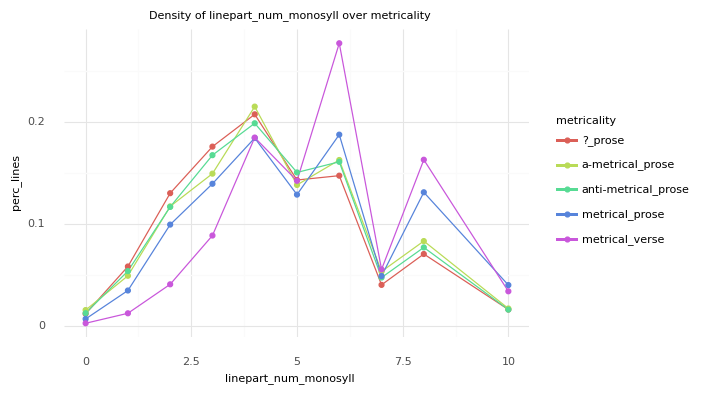

<ggplot: (707528711)>

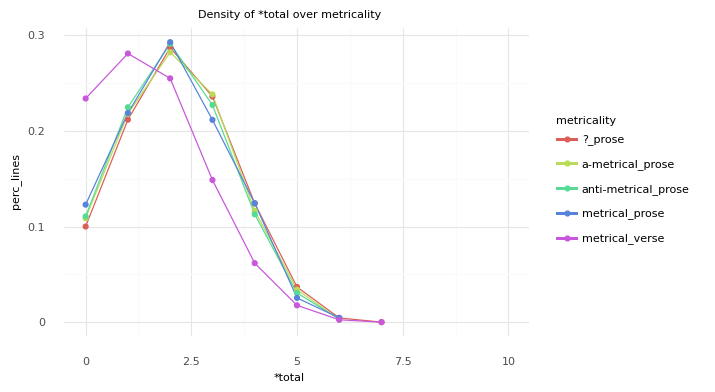

<ggplot: (703040073)>

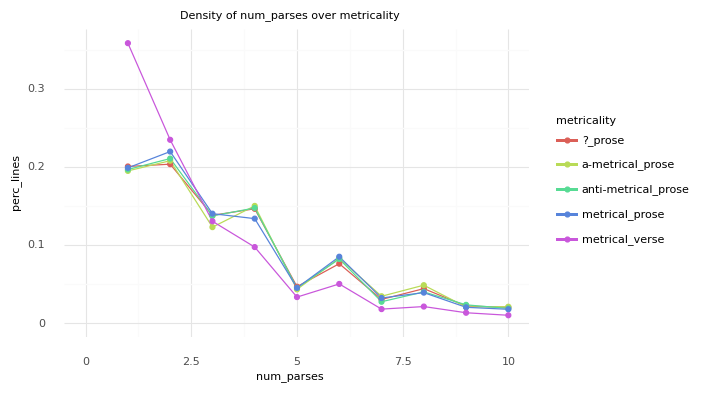

<ggplot: (746749754)>

In [206]:
for feat in feats:
    for aggby in ['metricality']:
    # for aggby in ['prosody','metricality']:
        display(plotfeat(feat,aggby,relative=True,incl_verse=True,wrap_prosody=False))

## Authors

In [207]:
gby=['id_author','prosody','metricality','century']
figdf=dfbest.groupby(gby).filter(lambda g: len(g)>=1)
figdf=figdf.groupby(gby).mean().reset_index()
# figdf=figdf[~figdf.metricality.str.startswith('?')]
figdf['label']=figdf['id_author'].apply(lambda x: x.title())
figdf['id_type']='author'
figdf

avgmetr=figdf.groupby(['prosody','metricality']).mean().reset_index()
avgmetr['id_author']=avgmetr['label']=avgmetr['metricality']
avgmetr['id_type']='metricality'
figdf=figdf.append(avgmetr)
figdf

figdf=figdf.query('19>=century_int>=14')
figdf.loc[figdf.century_int<=16, 'century']='C14-C16'

avgmetr=figdf.groupby(['prosody','century']).mean().reset_index()
avgmetr['id_author']=avgmetr['label']=[f'{x} {y}' for x,y in zip(avgmetr['century'],avgmetr['prosody'])]
avgmetr['id_type']='century'
figdf=figdf.append(avgmetr)
figdf['centpros']=[f'{x} {y}' for x,y in zip(figdf['century'],figdf['prosody'])]
# figdf

In [208]:
# figdf[figdf.id_author=='donne']

In [209]:
dfbest.prosody.value_counts()

Verse    51389
Prose    38291
Name: prosody, dtype: int64

In [210]:
def plotauth(figdf,feat='*total',x='linepart_num_monosyll'):
    fig=p9.ggplot(figdf[figdf['id_type']=='author'], p9.aes(x=x,y=feat,label='label'))
    fig+=p9.geom_hline(yintercept=figdf[feat].median(),size=.25)
    fig+=p9.geom_vline(xintercept=figdf[x].median(),size=.25)
    fig+=p9.geom_label(p9.aes(color='metricality'),size=9)
    fig+=p9.geom_label(data=figdf.query('id_type=="century" & prosody=="Prose"'), size=8,color='black')
    fig+=p9.geom_label(data=figdf.query('id_type=="century" & prosody=="Verse"'), size=8,color='black')
    fig+=p9.geom_smooth(method='lm',se=False,size=.5,linetype='dashed')
    p9.options.figure_size=16,8
    # fig+=p9.theme_minimal()
    fig+=p9.facet_wrap('century',nrow=1)
    # fig+=p9.scale_color_gray(start=0,end=.5)
    fig+=p9.scale_color_brewer(type='qual',palette=2)
    return fig

In [211]:
feats=[c for c in dfbest if c.startswith('num_parses') or c.startswith('*')]
feats=[
    'linepart_num_monosyll',
    '*total',
    'num_parses',
    '*w/peak',
    '*w/stressed',
    '*s/unstressed',
    '*w-res',
    '*f-res',
]

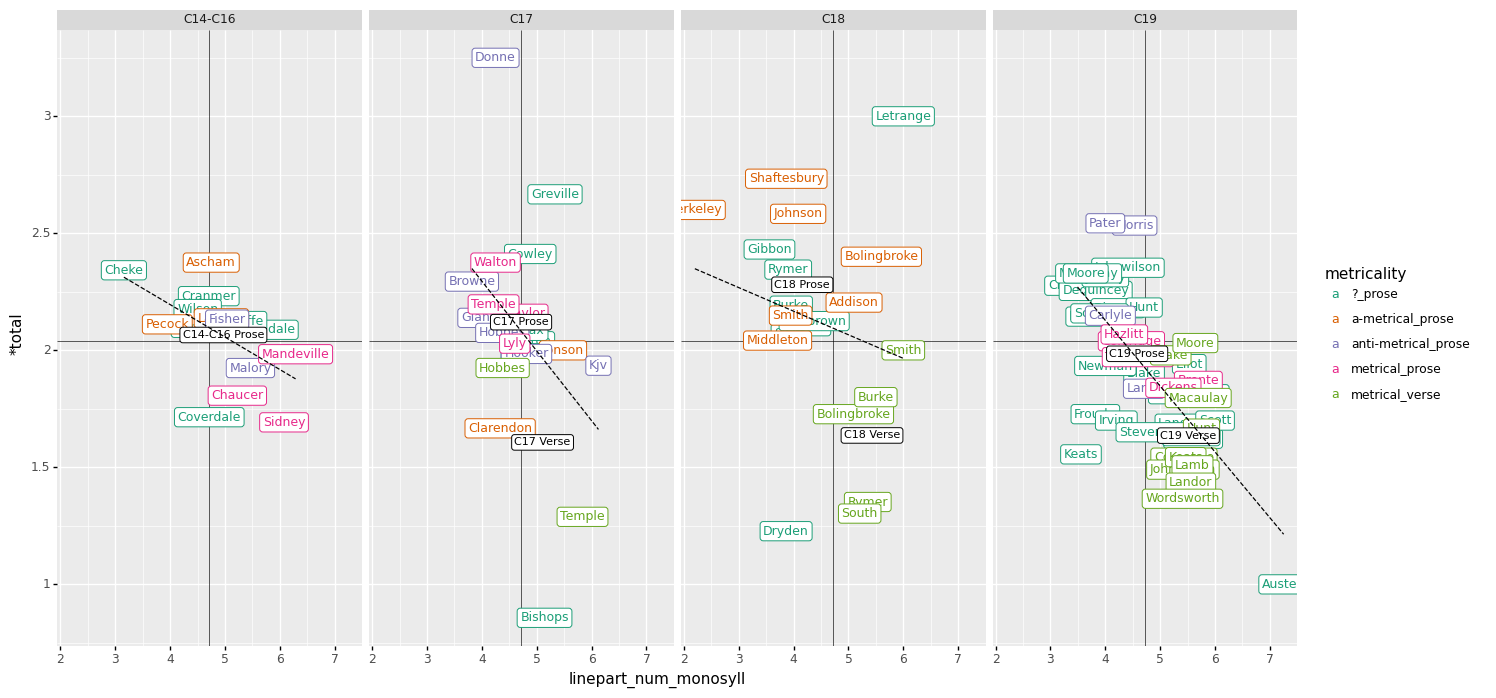

<ggplot: (703040073)>

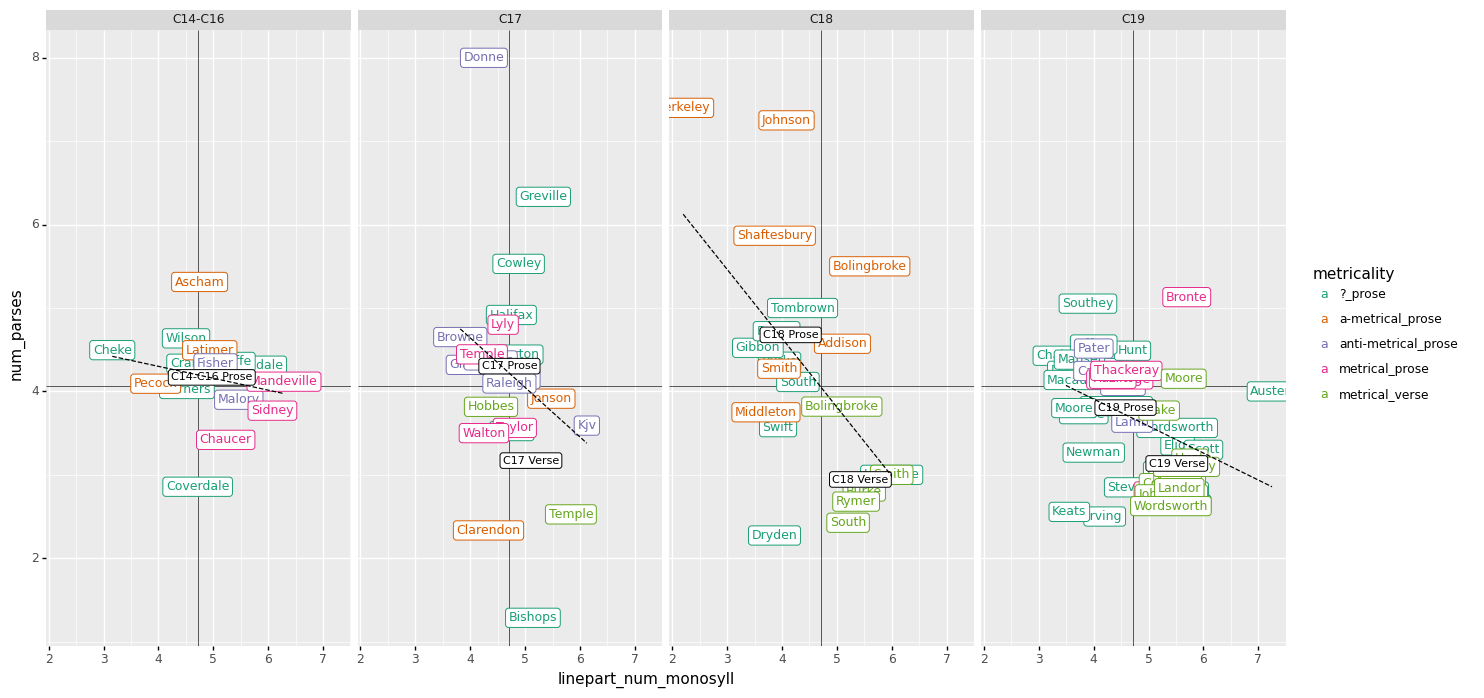

<ggplot: (714806932)>

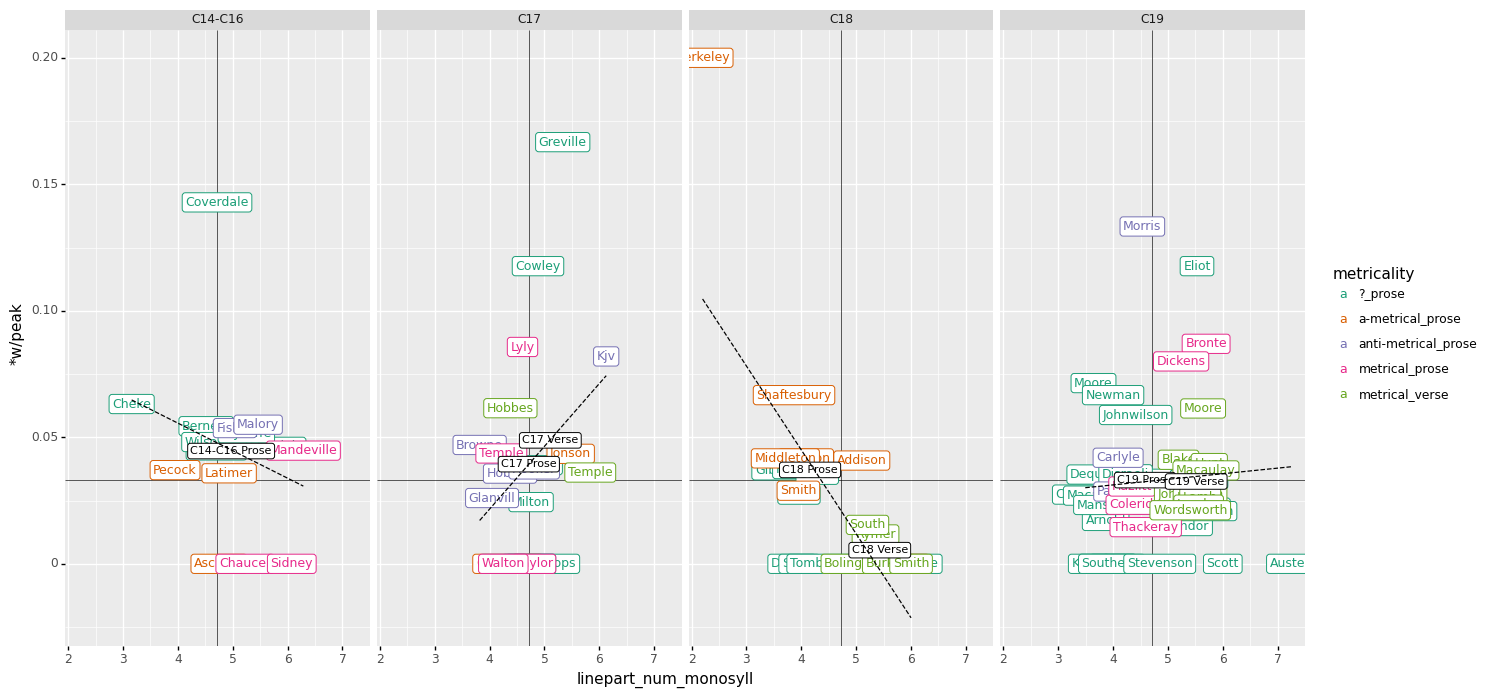

<ggplot: (713854236)>

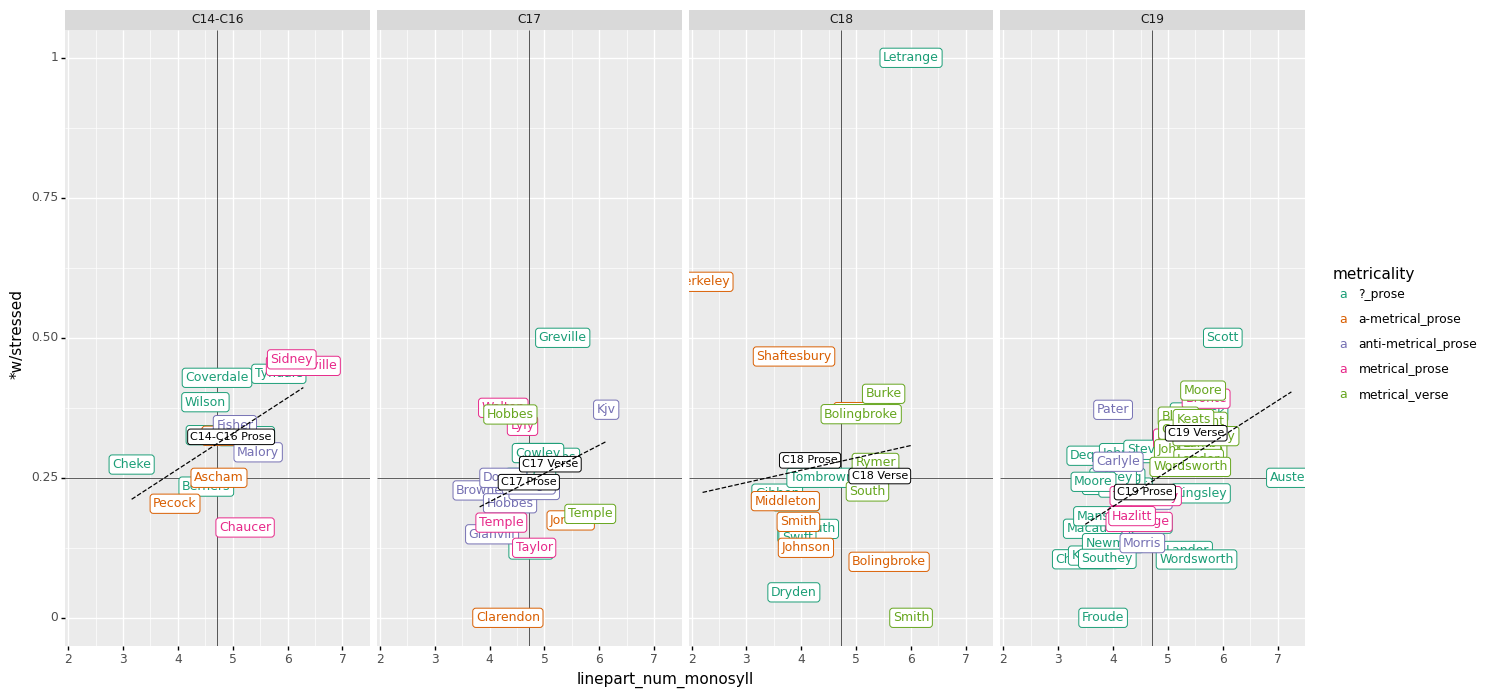

<ggplot: (746059138)>

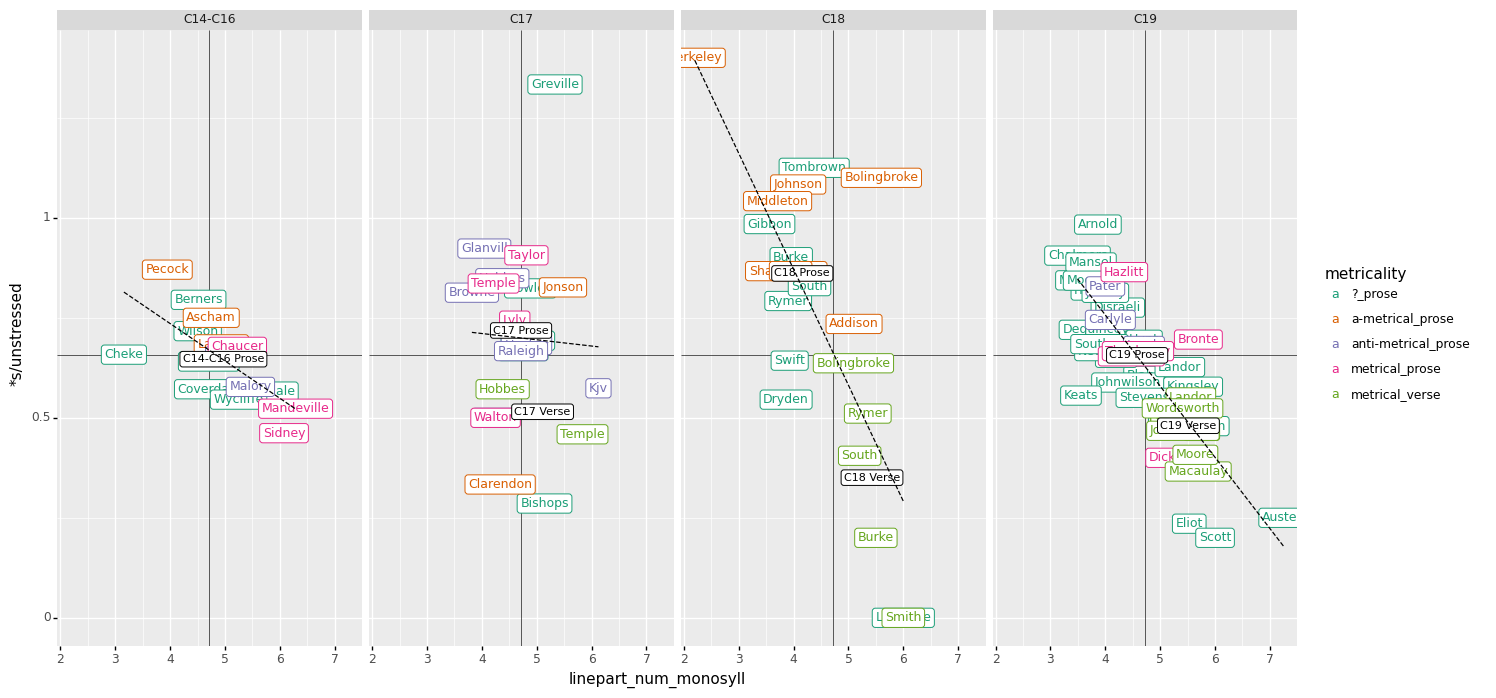

<ggplot: (699458437)>

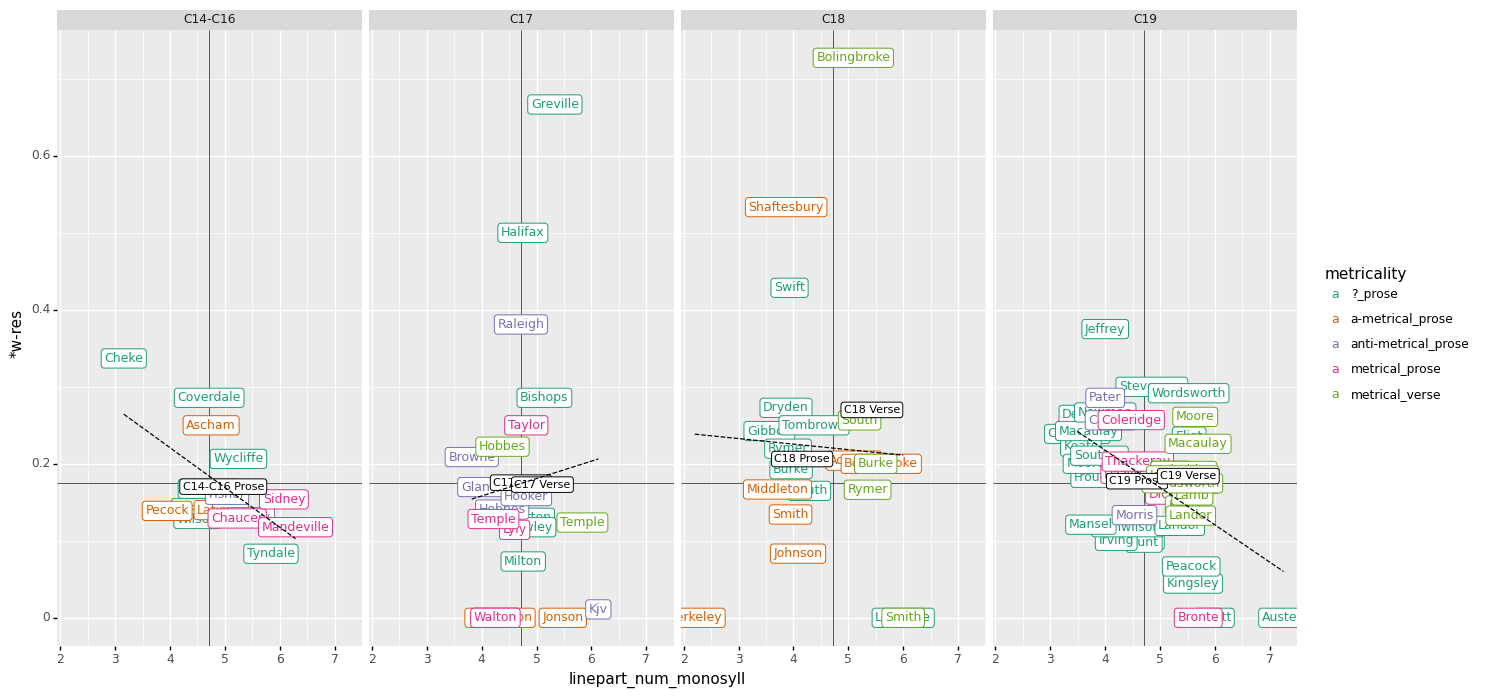

<ggplot: (742633271)>

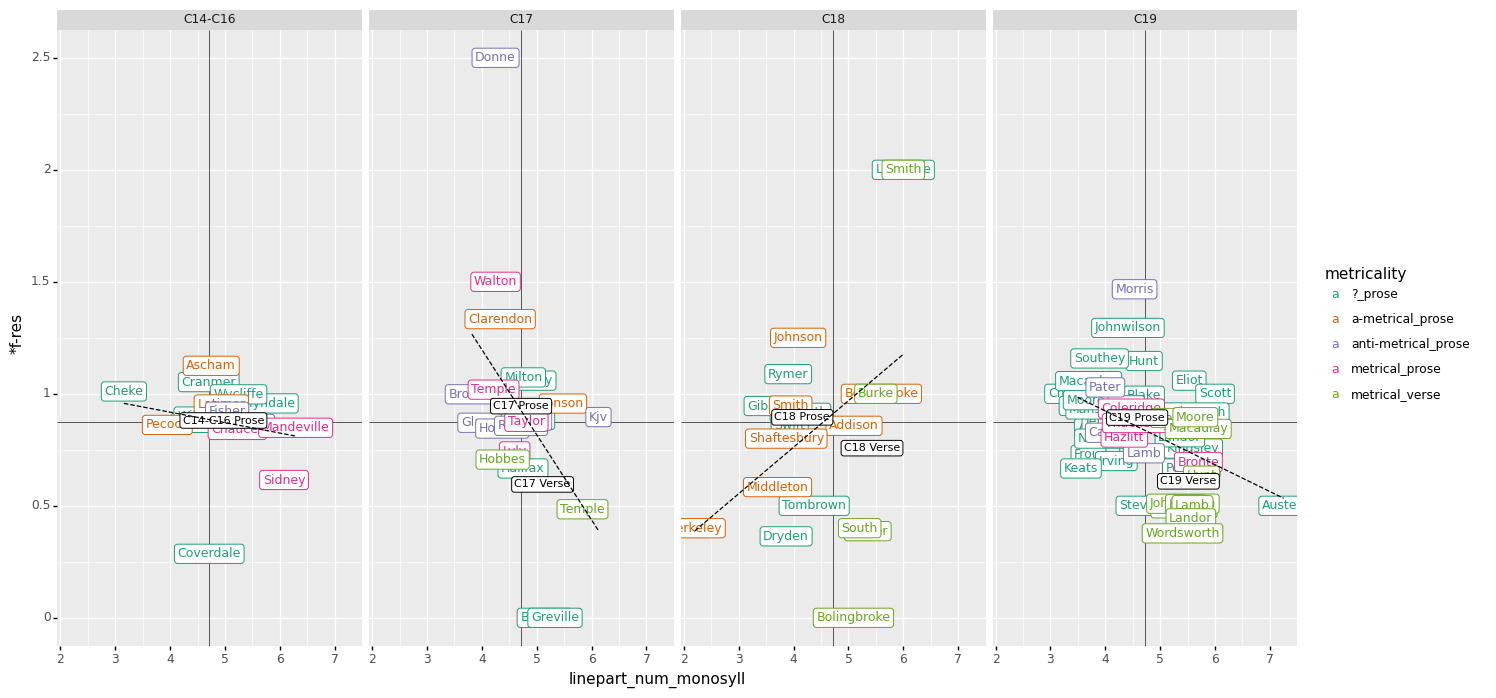

<ggplot: (702926111)>

In [212]:
for x in feats[1:]: display(plotauth(figdf,feat=x))

In [157]:
# figdf[figdf['metricality']=='anti-metrical_prose']

### By year

In [158]:
gby=['id_author','prosody','metricality','century']
yrfigdf=dfbest.groupby(gby).filter(lambda g: len(g)>=1)
yrfigdf=figdf.groupby(gby).mean().reset_index()
yrfigdf=yrfigdf[yrfigdf.prosody=='Prose']
yrfigdf=yrfigdf.query('year_au>=1300')
yrfigdf

,id_author,prosody,metricality,century,stanza_i,line_i,linepart_i,parse_rank,is_troch,parse_i,combo_i,parse_is_bounded,parse_num_syll,is_stressed,is_trough,is_unstressed,prom_strength,is_light,linepart_num_monosyll,is_peak,*w-res,*f-res,prom_weight,*total,is_w,linepart_num_syll,is_heavy,*w/stressed,*w/peak,*s/unstressed,num_parses,parse_num_pos,is_funcword,prom_stress,is_s,year,century_int,year_au
0,addison,Prose,a-metrical_prose,C18,1.000000,25.877551,3.367347,1.0,0.510204,1.448980,1.102041,0.0,10.0,4.244898,2.346939,5.755102,2.102041,0.0,5.102041,2.102041,0.204082,0.857143,0.0,2.204082,5.387755,10.0,0.0,0.367347,0.040816,0.734694,4.571429,8.979592,3.081633,4.153061,4.612245,NaN,18.0,1719.0
1,anti-metrical_prose,Prose,anti-metrical_prose,C14-C16,60.256855,11.798567,3.284436,1.0,0.489279,1.242141,1.061426,0.0,10.0,4.248670,2.402265,5.751330,2.115087,0.0,5.129254,2.115087,0.155818,0.995505,0.0,2.114812,5.367631,10.0,0.0,0.271951,0.035767,0.655771,4.239866,8.895243,3.041910,4.154101,4.632369,1683.298528,15.5,1499.0
2,arnold,Prose,?_prose,C19,2.661017,8.016949,4.694915,1.0,0.491525,1.406780,1.220339,0.0,10.0,3.898305,2.949153,6.101695,2.440678,0.0,3.864407,2.440678,0.203390,0.847458,0.0,2.288136,5.355932,10.0,0.0,0.237288,0.016949,0.983051,4.186441,9.152542,2.474576,3.762712,4.644068,NaN,19.0,1888.0
3,ascham,Prose,a-metrical_prose,C14-C16,1.000000,3.687500,4.062500,1.0,0.312500,1.250000,1.187500,0.0,10.0,4.125000,2.437500,5.875000,2.312500,0.0,4.750000,2.312500,0.250000,1.125000,0.0,2.375000,5.375000,10.0,0.0,0.250000,0.000000,0.750000,5.312500,8.937500,2.937500,4.062500,4.625000,NaN,16.0,1568.0
4,austen,Prose,?_prose,C19,1.000000,1.000000,3.250000,1.0,0.750000,1.250000,1.250000,0.0,10.0,4.250000,1.500000,5.750000,1.250000,0.0,7.250000,1.250000,0.000000,0.500000,0.0,1.000000,5.750000,10.0,0.0,0.250000,0.000000,0.250000,4.000000,8.500000,4.250000,4.250000,4.250000,NaN,19.0,1817.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,tyndale,Prose,?_prose,C14-C16,27.404752,3.703437,2.208316,1.0,0.470089,1.423844,1.105218,0.0,10.0,4.552821,2.009758,5.447179,1.924056,0.0,5.840899,1.924056,0.083157,0.957149,0.0,2.087824,5.317777,10.0,0.0,0.435723,0.046245,0.565549,4.308443,8.885023,3.258804,4.447179,4.682223,1840.361088,16.0,1536.0
95,walton,Prose,metrical_prose,C17,1.000000,1.250000,8.125000,1.0,0.250000,1.000000,1.000000,0.0,10.0,4.500000,2.875000,5.500000,2.625000,0.0,4.250000,2.625000,0.000000,1.500000,0.0,2.375000,5.375000,10.0,0.0,0.375000,0.000000,0.500000,3.500000,9.125000,2.375000,4.500000,4.625000,NaN,17.0,1683.0
96,wilson,Prose,?_prose,C14-C16,28.374332,2.588235,3.347594,1.0,0.470588,1.374332,1.069519,0.0,10.0,4.395722,2.636364,5.604278,2.454545,0.0,4.502674,2.454545,0.128342,0.898396,0.0,2.176471,5.272727,10.0,0.0,0.385027,0.048128,0.716578,4.636364,9.096257,2.614973,4.275401,4.727273,1551.000000,16.0,1581.0
97,wordsworth,Prose,?_prose,C19,10.208333,1.729167,3.812500,1.0,0.500000,1.125000,1.104167,0.0,10.0,4.062500,2.270833,5.937500,2.000000,0.0,5.520833,2.000000,0.291667,0.916667,0.0,1.812500,5.562500,10.0,0.0,0.104167,0.020833,0.479167,3.562500,8.645833,3.541667,3.968750,4.437500,1800.000000,19.0,1850.0


In [159]:
def plotyr(feat='*total'):
    yrfigdf['feat']=yrfigdf[feat]
    fig=p9.ggplot(yrfigdf, p9.aes(x='year_au',y='feat',label='id_author'))
    fig+=p9.geom_text(p9.aes(color='metricality'))
    fig+=p9.geom_smooth()
    fig+=p9.theme_minimal()
    fig+=p9.labs(title=feat, y=feat)# + ' /10 monosyll')
    fig+=p9.scale_color_brewer(type='qual',palette=2)
    return fig

In [129]:
feats=[c for c in dfbest if c.startswith('num_parses') or c.startswith('*')]
feats=[
    'linepart_num_monosyll',
    '*total',
    'num_parses',
    '*w/peak',
    '*w/stressed',
    '*s/unstressed',
    '*w-res',
    '*f-res',
]

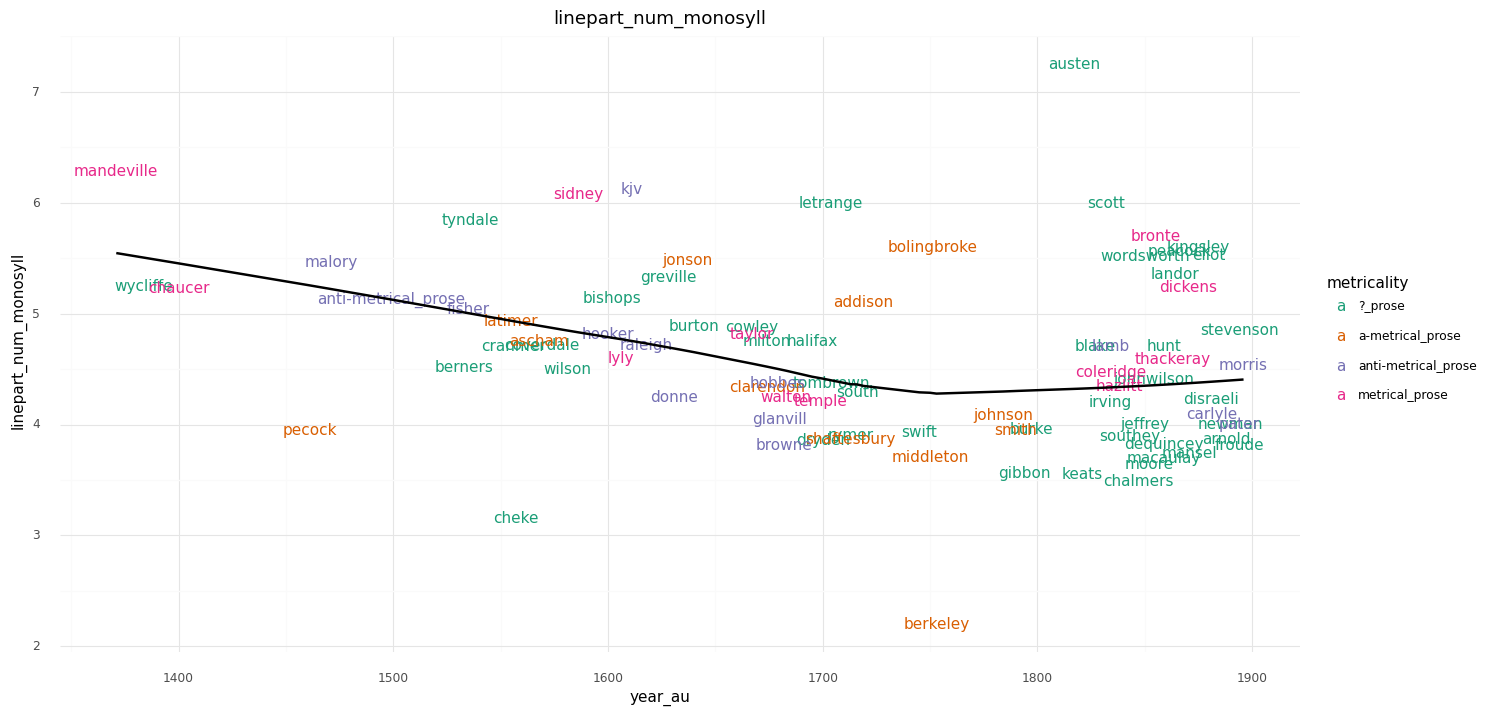

<ggplot: (703914870)>

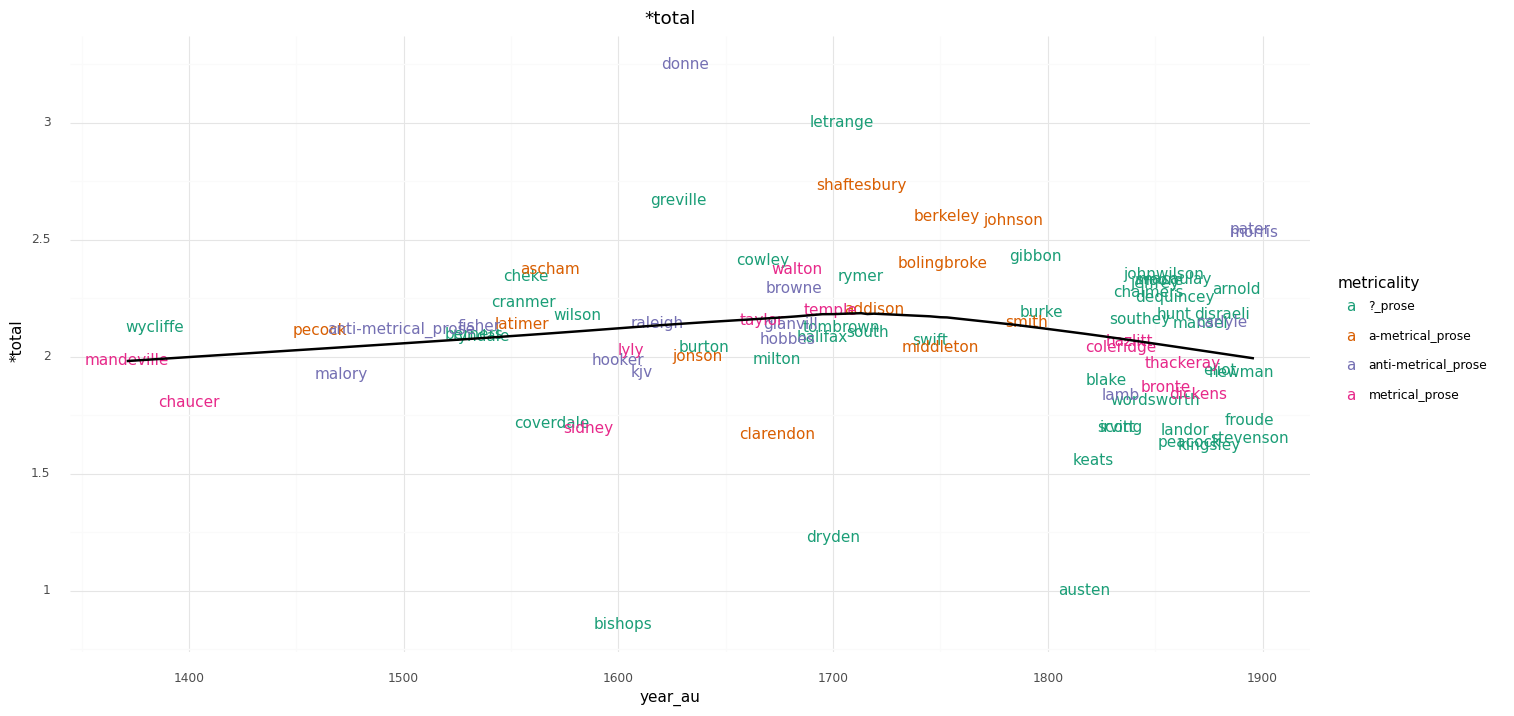

<ggplot: (703914870)>

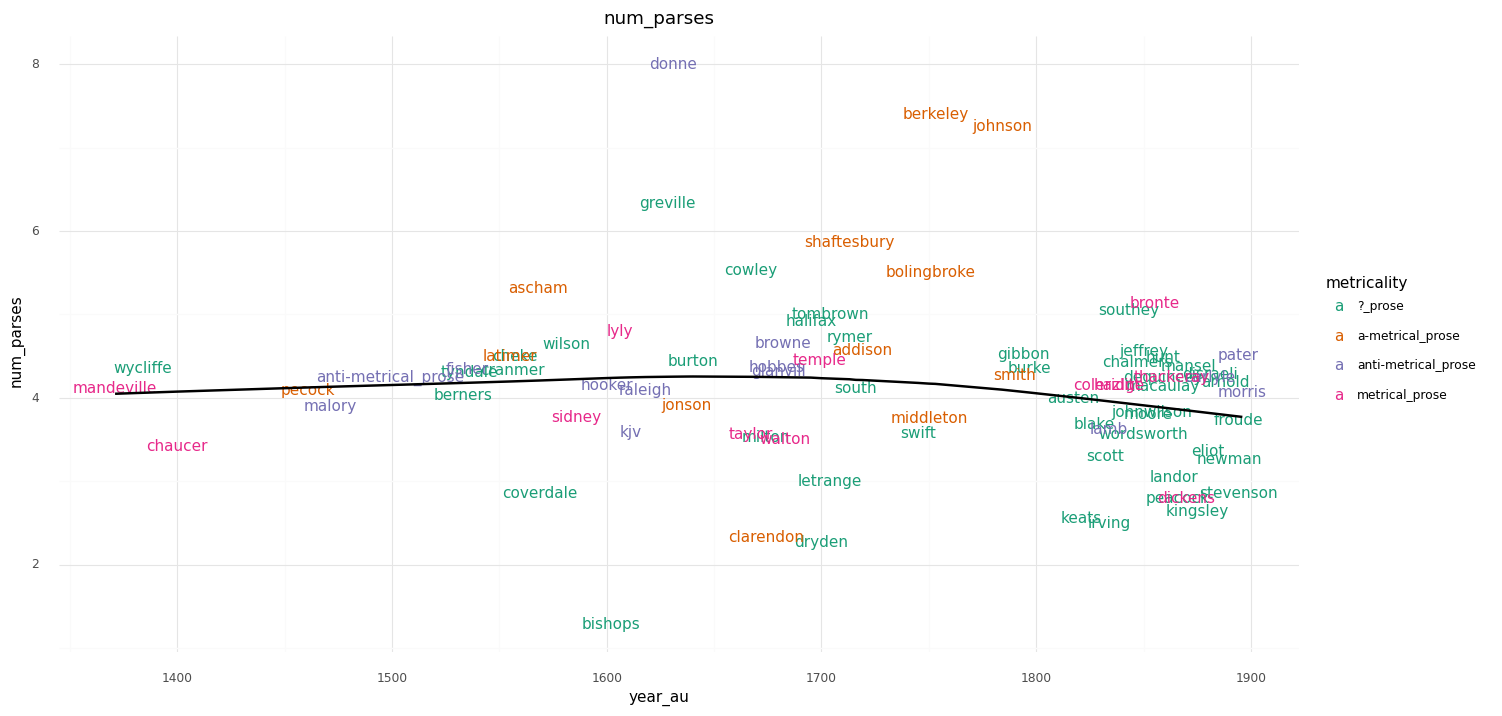

<ggplot: (703914870)>

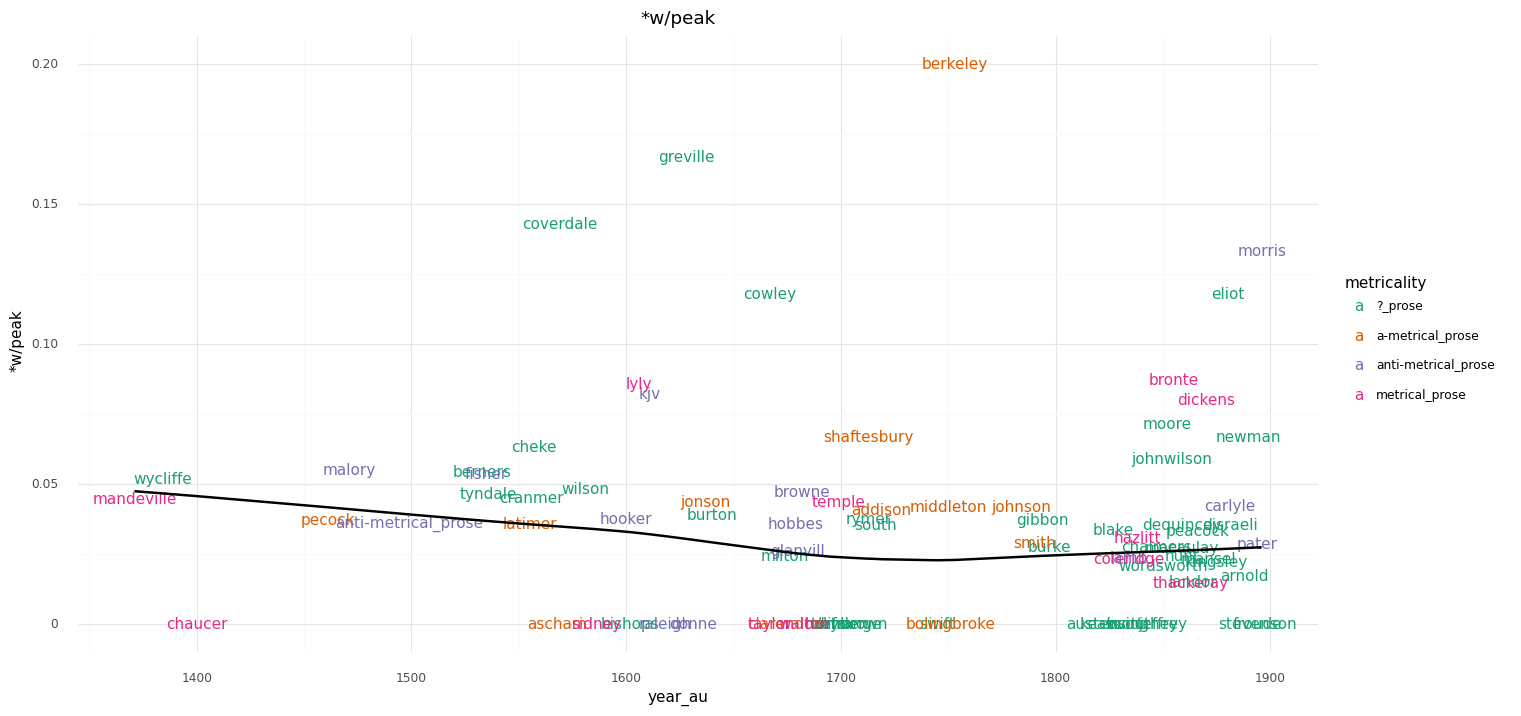

<ggplot: (699458341)>

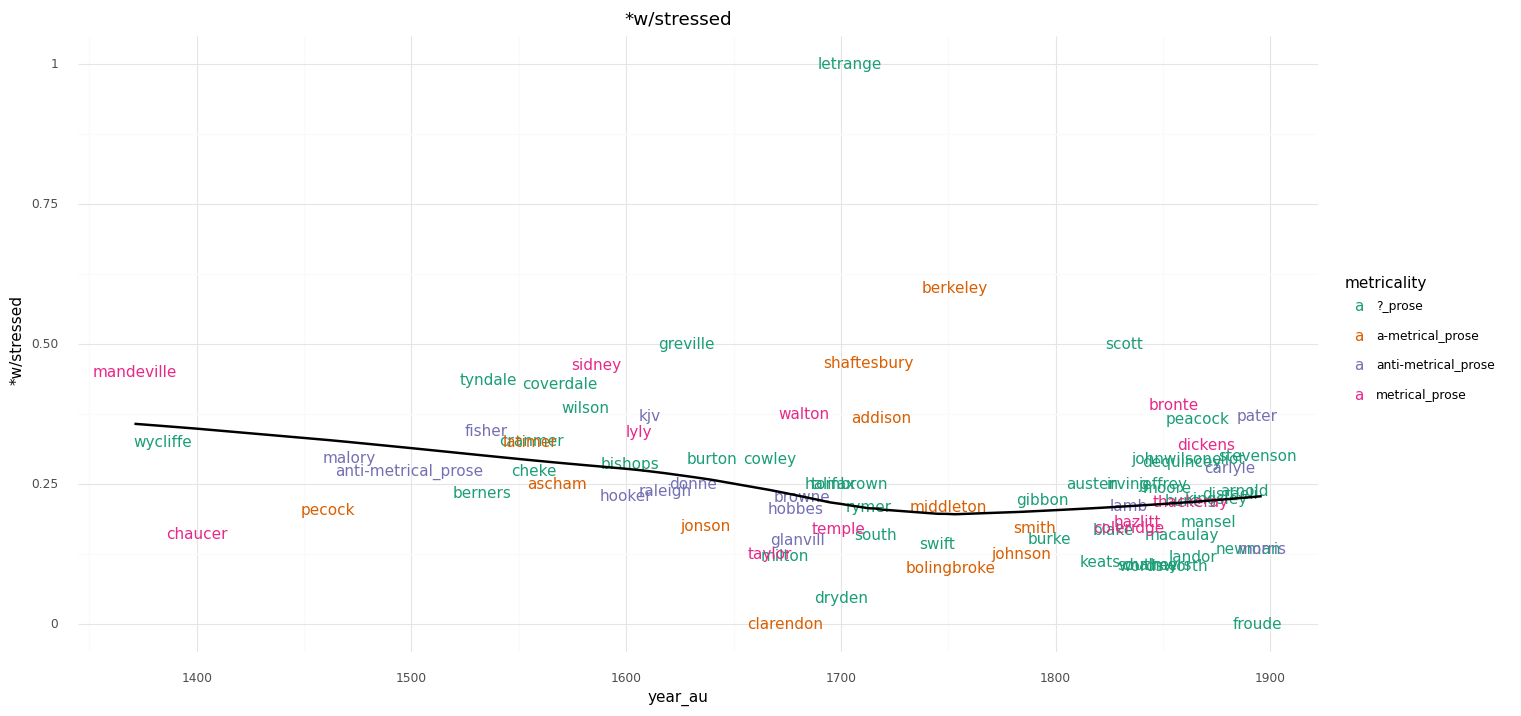

<ggplot: (702923301)>

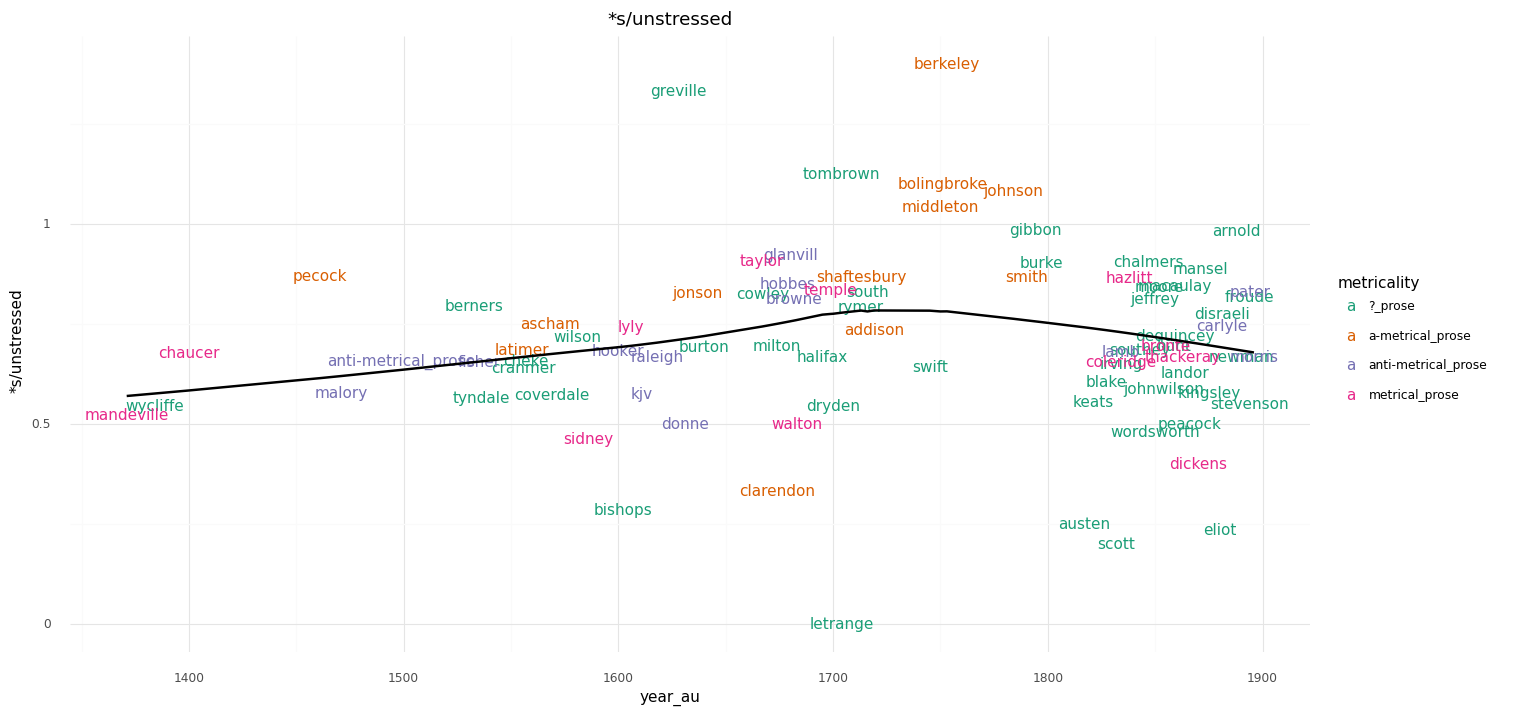

<ggplot: (730706192)>

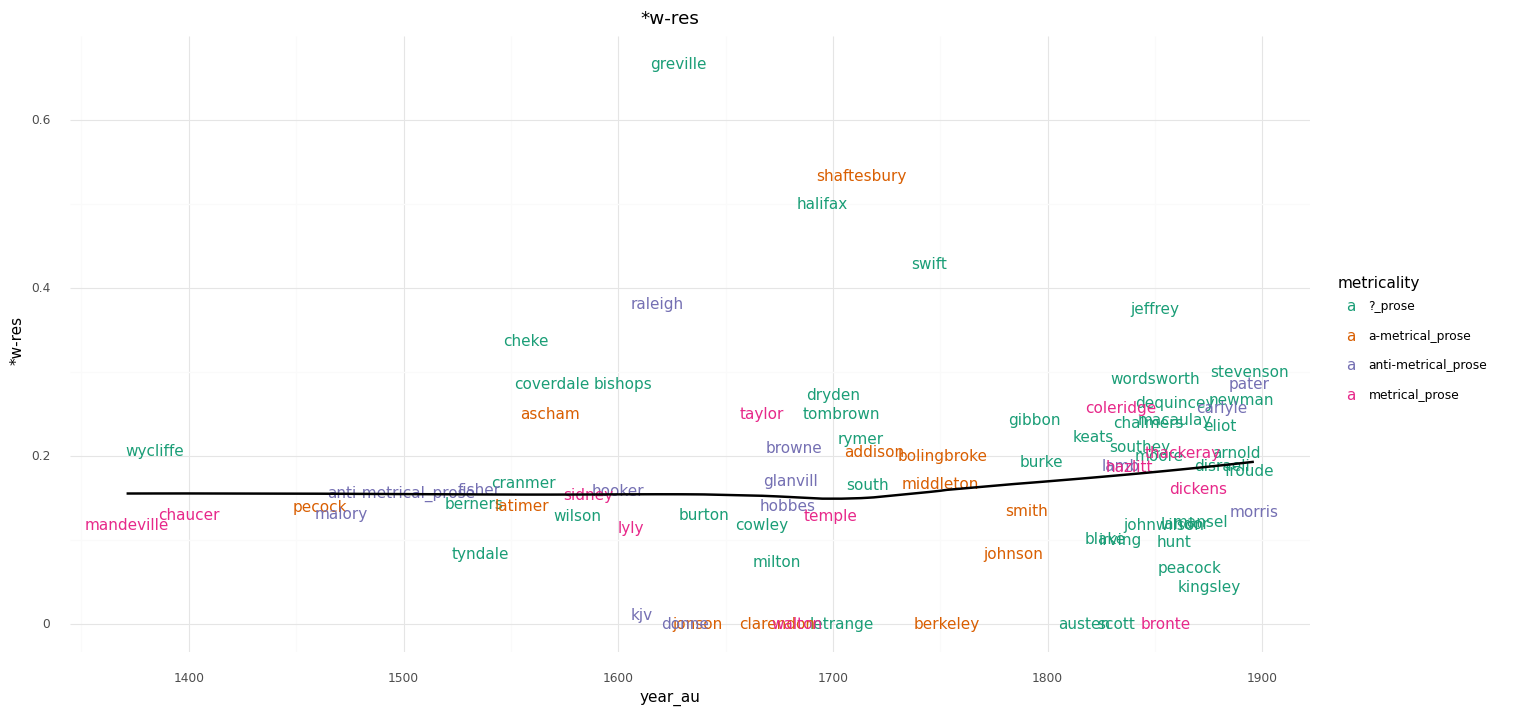

<ggplot: (747821972)>

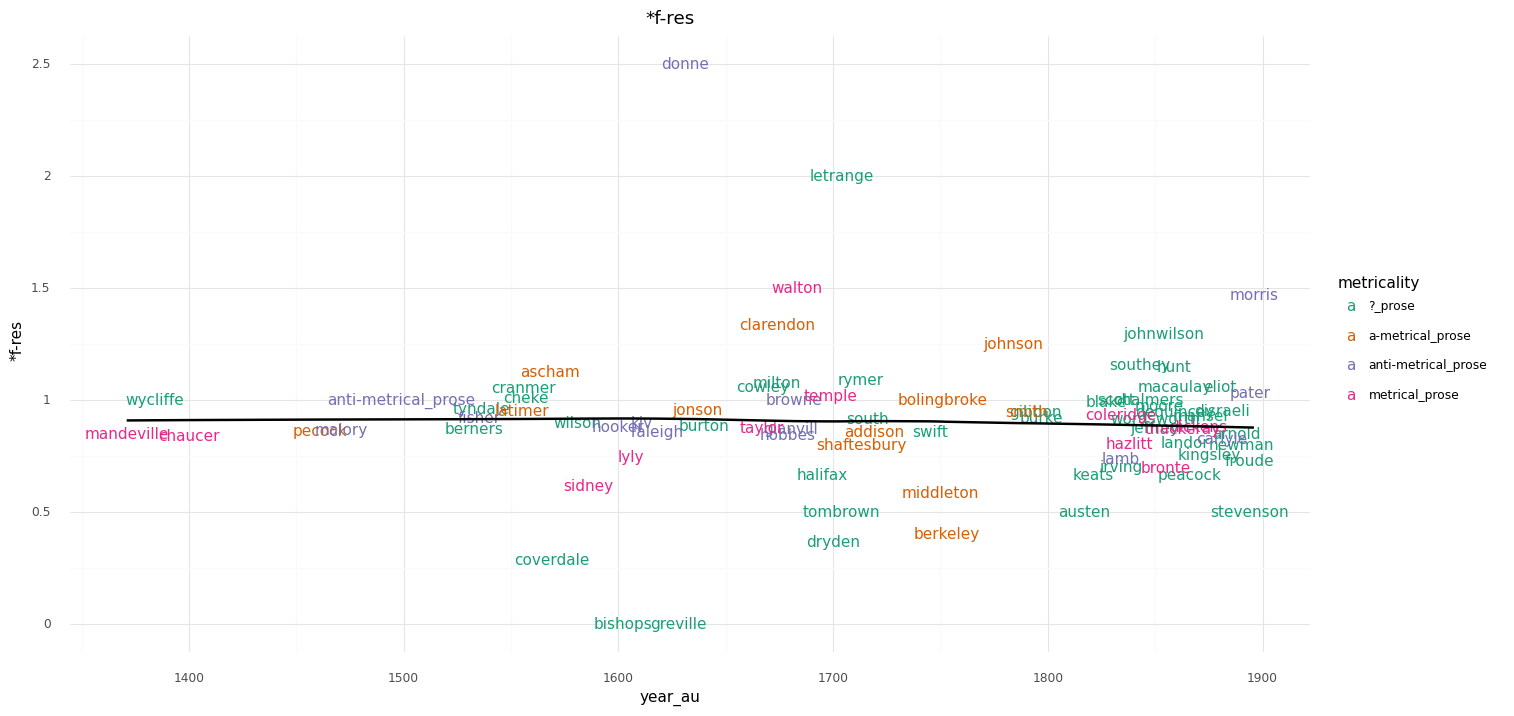

<ggplot: (704042481)>

In [160]:
for x in feats: display(plotyr(x))